# Introduction
In this article [Shahul](https://shahules786.github.io/) and I ([Vignesh Baskaran](https://vigneshbaskar.github.io/)) try to summarize our learnings from the Kaggle Commonlit competition. We are happy that we managed to secure the 40th position in this competition amongst 3633 teams. But deep in our heart we firmly believe it doesn't matter which position one ends up in, but what matters is the learnings each one of us get out of it. We respect every single participant in this competition. We wouldn't have managed to learn so much without all of you. Thank you very much.

This competition was organized by Commonlit. CommonLit is a nonprofit education technology organization dedicated to ensuring that all students, especially students in Title I schools, graduate with the reading, writing, communication, and problem-solving skills they need to be successful in college and beyond.

# Competition objective
In this competition we are provided with a list of short text excerpts and their corresponding score which indicates how difficult it is to read the text. These scores were computed using Bradley Terry method in which pairs of texts are compared by several examiners and they manually classify which text among the pair is difficult to read. For instance here is a pair of text:

**Text 1**:
> Every day, Emeka's father took him to school in his car. He also brought Emeka home after school. One afternoon on their way home, Emeka's father stopped to buy something at a big shop. From the car, Emeka looked across the road and saw an old man. He was carrying a big load on his head. He was tired and walked slowly. Emeka kept looking at him. The old man sat under the shade of a tree on the walkway and opened his bag.

**Text 2**:
>The nature of incrustation and the evils resulting therefrom having been stated, it now remains to consider the methods that have been devised to overcome them. These methods naturally resolve themselves into two kinds, chemical and mechanical. The chemical method has two modifications; in one the design is to purify the water in large tanks or reservoirs, by the addition of certain substances which shall precipitate all the scale-forming ingredients before the water is fed into the boiler; in the other the chemical agent is fed into the boiler from time to time, and the object is to effect the precipitation of the saline matter in such a manner that it will not form solid masses of adherent scale

Here are the ratings offered by 5 examiners who compared this pair of text  

|            | Easy Text |
|------------|-----------|
| Examiner 1 | Text 1    |
| Examiner 2 | Text 1    |
| Examiner 3 | Text 1    |
| Examiner 4 | Text 2    |
| Examiner 5 | Text 1    |

In this way several pairs of texts are compared by multiple examiners and based on their labels, scores are assigned to each text excerpt. The scores range from (-3, 2). The higher the score is the easier it is to read.


In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from transformers import AdamW, AutoTokenizer
from commonlit_nn_kit import clear_cuda, get_scheduler, get_optimizer_parameters, create_uno_text_dataloader, RobertaMaskAddedAttentionHeadRegressor
from commonlit_nn_kit import compute_mse_loss, compute_rmse_loss, compute_rmse_score, forward_pass_uno_text_batch, Saver, UnoStacker, train_and_evaluate

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
config = {'seed': 42}

# Competition data
Here is a sample of competition data. We split the data into five folds in a stratified fashion based on the target scores.

In [3]:
competition_data = pd.read_csv("commonlit-splits/commonlittrain_stratified_simple.csv")[['excerpt', 'target', 'fold']]
with pd.option_context("display.max_colwidth", None):
    display(competition_data.sample(2, random_state=config['seed']))

,excerpt,target,fold
2089,"Alice looked at the jury-box, and saw that, in her haste, she had put the Lizard in head downwards, and the poor little thing was waving its tail about in a melancholy way, being quite unable to move. She soon got it out again, and put it right; ‘not that it signifies much,' she said to herself; ‘I should think it would be quite as much use in the trial one way up as the other.'\nAs soon as the jury had a little recovered from the shock of being upset, and their slates and pencils had been found and handed back to them, they set to work very diligently to write out a history of the accident, all except the Lizard, who seemed too much overcome to do anything but sit with its mouth open, gazing up into the roof of the court.\n‘What do you know about this business?' the King said to Alice.\n‘Nothing,' said Alice.\n‘Nothing whatever?' persisted the King.\n‘Nothing whatever,' said Alice.",-0.432678,2
2806,"Artificial intelligence (AI) is intelligence exhibited by machines. In computer science, an ideal ""intelligent"" machine is a flexible rational agent that perceives its environment and takes actions that maximize its chance of success at some goal. Colloquially, the term ""artificial intelligence"" is applied when a machine mimics ""cognitive"" functions that humans associate with other human minds, such as ""learning"" and ""problem solving"". As machines become increasingly capable, facilities once thought to require intelligence are removed from the definition. For example, optical character recognition is no longer perceived as an exemplar of ""artificial intelligence"" having become a routine technology. Capabilities still classified as AI include advanced Chess and Go systems and self-driving cars.\nAI research is divided into subfields that focus on specific problems or on specific approaches or on the use of a particular tool or towards satisfying particular applications.",-1.161746,3


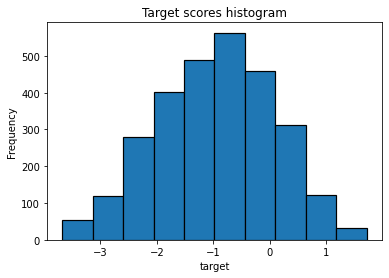

In [4]:
plt.hist(competition_data.target.to_numpy(),  edgecolor='black', linewidth=1.2)
plt.title('Target scores histogram')
plt.xlabel('target')
plt.ylabel('Frequency')
plt.show()

### Very easy text

In [5]:
with pd.option_context("display.max_colwidth", None):
    display(competition_data.query("target>1.5").sample(1, random_state=config['seed']))

,excerpt,target,fold
981,"For her last birthday, Sisanda had a special treat – her parents got permission for her to have a party at the game reserve. The giraffes at the reserve were curious about this group of people. They stretched out their long necks for the best view of the party and they even seemed to want some of the birthday cake! Sisanda loved the giraffes. All animals were special to her, but it was the quiet and gentle giraffes that stole her heart. She could spend all day watching them. \nOne Friday, Sisanda's father came home from work early. He looked very upset. ""What's wrong, Baba?"" Sisanda asked. ""Today a swarm of bees stung a mother giraffe,"" explained Sisanda's father. ""Her head was so swollen from all the stings that her beautiful eyes were closed. We tried everything to help her, but it was no use – she died. And the saddest part of all is that she had a young calf that still needs her.""",1.59787,3


### Very difficult text

In [6]:
with pd.option_context("display.max_colwidth", None):
    display(competition_data.query("target<-3").sample(1, random_state=config['seed']))

,excerpt,target,fold
457,"The light-year is a unit of length used to express astronomical distances and measures about 9.46 trillion kilometres (9.46 x 1012 km) or 5.88 trillion miles (5.88 x 1012 mi). As defined by the International Astronomical Union (IAU), a light-year is the distance that light travels in vacuum in one Julian year (365.25 days).Because it includes the word ""year"", the term light-year may be misinterpreted as a unit of time.\nThe light-year is most often used when expressing distances to stars and other distances on a galactic scale, especially in non-specialist and popular science publications. The unit most commonly used in professional astrometry is the parsec (symbol: pc, about 3.26 light-years; the distance at which one astronomical unit subtends an angle of one second of arc).\n As defined by the IAU, the light-year is the product of the Julian year (365.25 days as opposed to the 365.2425-day Gregorian year) and the speed of light (299792458 m/s). Both of these values are included in the IAU (1976) System of Astronomical Constants, used since 1984.",-3.256312,2


## Stratified Kfold splitting vs Simple Kfold splitting
The Simple Kfold splitting randomly splits the data into folds, whereas the stratified Kfold splitting takes group information into account to avoid building folds with imbalanced class distributions. In our case we experimented with training models on both simple splitting and stratified splitting. We observed that for the Roberta large model the public LB increased with stratified Kfold whereas with base model the public LB increased with simple Kfold. Although our gut feeling says that stratified Kfold is the right way to go about we had a couple of models in our ensemble trained using simple Kfold just to make it diversified. 

## Training data size

In [7]:
print(f'Number of samples in the training data: {len(competition_data)}')

Number of samples in the training data: 2834


Owing to the very small size of the dataset we were worried that our models would overfit the data. Therefore we looked into several ways to prevent overfitting. One of the solutions which worked exceptionally very well in the very last minute was pretraining the models with large amount of external data. 

# External data
We came to know that Wikipedia has a project called Simple Wikipedia in its umbrella. The Simple English Wikipedia is an English-language edition of the Wikipedia written primarily in Basic English and Learning English. Simple English Wikipedia's basic presentation style makes it very helpful for beginners learning English. Its simpler word structure and syntax, while detracting from the raw information standpoint, can make the information easy to understand.

[Mark Wijkhuizen](https://www.kaggle.com/markwijkhuizen) published a clean version of Wikipedia and Simple Wikipedia pairs [here](https://www.kaggle.com/markwijkhuizen/simplenormal-wikipedia-sections). The column easy text comes from Simple Wikipedia and the column difficult text comes from Wikipedia.

In [8]:
external_data = pd.read_csv("data/external_data/wikipedia_sections_without_first_sentence.csv")
external_data = external_data[['title', 'section', 'easy_text', 'difficult_text']]

with pd.option_context("display.max_colwidth", 300):
    display(external_data.sample(3, random_state=config['seed']))

,title,section,easy_text,difficult_text
16115,Epstein–Barr virus,Abstract,"It is one of the most common viruses in humans. EBV is best known as the cause of infectious mononucleosis (glandular fever). It is also associated with some forms of cancer, such as Hodgkin's lymphoma, and conditions associated with human immunodeficiency virus (HIV). EBV may be associated with...","EBV is a double-stranded DNA virus. It is best known as the cause of infectious mononucleosis (""mono"" or ""glandular fever""). It is also associated with various non-malignant, premalignant, and malignant Epstein–Barr virus-associated lymphoproliferative diseases such as Burkitt lymphoma, hemophag..."
15807,Substitute (association football),Abstract,"Substitutions can be made for many reasons. Sometimes, they are made to replace a player who has become tired or injured. Substitutes can also replace a player who is playing poorly, or can be for tactics. For example, substitute strikers can be brought on for defenders if the team needs to atta...","Substitutions are generally made to replace a player who has become tired or injured, or who is performing poorly, or for tactical reasons (such as bringing a striker on in place of a defender). Unlike some sports (such as American football, ice hockey or kabaddi), but like in baseball, a player..."
22575,Ford Pinto,Abstract,The vehicle was marketed under Ford Motor Company in the States and Canada. It was made from the 1971 to 1980 model years. Pinto was the smallest American Ford car since 1907. It was Ford's first subcompact vehicle in North America. The Pinto was manufactured in three body styles: two-door sedan...,"The smallest American Ford vehicle since 1907, the Pinto was the first subcompact vehicle produced by Ford in North America. The Pinto was marketed in three body styles through its production: a two-door fastback sedan with a trunk, a three-door hatchback, and a two-door station wagon. Mercury o..."


# Competition DataLoader

In [9]:
config.update({'fold': 0, 'batch_size': 4, 'apply_preprocessing': False})

train_data, valid_data = competition_data[competition_data['fold'] != config['fold']], competition_data[competition_data['fold']==config['fold']]
print(f'Number of samples in the train_data: {len(train_data)}')
print(f'Number of sample in the valid_data: {len(valid_data)}')

Number of samples in the train_data: 2267
Number of sample in the valid_data: 567


### Dataset Definition
```python
class UnoTextDataset(Dataset):
    def __init__(self, text_excerpts, targets):
        self.text_excerpts = text_excerpts
        self.targets = targets
    
    def __len__(self):
        return len(self.text_excerpts)
    
    def __getitem__(self, idx):
        sample = {'text_excerpt': self.text_excerpts[idx],
                  'target': self.targets[idx]}
        return sample
```

```python
class DuoTextDataset(Dataset):
    """
    If the first input is easier to read then the target is 1
    If the second input is easier to read then the target is -1
    """
    def __init__(self, text_excerpts_left, text_excerpts_right, targets):
        self.text_excerpts_left = text_excerpts_left
        self.text_excerpts_right = text_excerpts_right
        self.targets = targets
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        sample = {'text_excerpt_left': self.text_excerpts_left[idx],
                  'text_excerpt_right': self.text_excerpts_right[idx],
                  'target': self.targets[idx]}
        return sample
```

In [10]:
train_dataloader = create_uno_text_dataloader(data=train_data, batch_size=config['batch_size'], shuffle=True, sampler=None, apply_preprocessing=config['apply_preprocessing'])
valid_dataloader = create_uno_text_dataloader(data=valid_data, batch_size=config['batch_size'], shuffle=False, sampler=None, apply_preprocessing=config['apply_preprocessing'])
print(f'Number of batches in the train_dataloader: {len(train_dataloader)}')
print(f'Number of batches in the valid_dataloader: {len(valid_dataloader)}')

Number of batches in the train_dataloader: 567
Number of batches in the valid_dataloader: 142


# Tokenizer
The tokenizer gives out two fields: 
1. `input_ids` of shape `(batch_size, max_num_tokens)` which maps each token to the vocabulary 
2. `attention_mask` of shape `(batch_size, max_num_tokens)` which provides info on the `<PAD>` tokens

In [11]:
model_size = 'base'
config = {'tokenizer_name': f'data/robertas/roberta-{model_size}'}

In [12]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=config['tokenizer_name'])
tokenized_data = tokenizer(text=next(iter(train_dataloader))['text_excerpt'], truncation=True, padding=True, return_tensors='pt')
print(tokenized_data.keys())
print(f"Input IDs shape: {tokenized_data['input_ids'].shape} ")
print(f"Attention mask shape: {tokenized_data['attention_mask'].shape} ")

dict_keys(['input_ids', 'attention_mask'])
Input IDs shape: torch.Size([4, 233]) 
Attention mask shape: torch.Size([4, 233]) 


# Model
---
```python
class AttentionHead(nn.Module):
    def __init__(self, input_dim, head_hidden_dim):
        super(AttentionHead, self).__init__()
        head_hidden_dim = input_dim if head_hidden_dim is None else head_hidden_dim
        self.W = nn.Linear(input_dim, head_hidden_dim)
        self.V = nn.Linear(head_hidden_dim, 1)
        
    def forward(self, x):
        attention_scores = self.V(torch.tanh(self.W(x)))
        attention_scores = torch.softmax(attention_scores, dim=1)
        attentive_x = attention_scores * x
        attentive_x = attentive_x.sum(axis=1)
        return attentive_x
```
---

```python
class MaskAddedAttentionHead(nn.Module):
    def __init__(self, input_dim, head_hidden_dim):
        super(MaskAddedAttentionHead, self).__init__()
        head_hidden_dim = input_dim if head_hidden_dim is None else head_hidden_dim
        self.W = nn.Linear(input_dim, head_hidden_dim)
        self.V = nn.Linear(head_hidden_dim, 1)
        
    def forward(self, x, attention_mask):
        attention_scores = self.V(torch.tanh(self.W(x)))
        attention_scores = attention_scores + attention_mask
        attention_scores = torch.softmax(attention_scores, dim=1)
        attentive_x = attention_scores * x
        attentive_x = attentive_x.sum(axis=1)
        return attentive_x
```
---

```python
class RobertaMaskAddedAttentionHeadRegressor(nn.Module):
    def __init__(self, model_path, dropout_prob=0.1, head_hidden_dim=None, roberta_hidden_dropout_prob=0.1,
                 roberta_attention_probs_dropout_prob=0.1, **kwargs):
        super(RobertaMaskAddedAttentionHeadRegressor, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_path,
                                                 hidden_dropout_prob=roberta_hidden_dropout_prob,
                                                 attention_probs_dropout_prob=roberta_attention_probs_dropout_prob, **kwargs)
        self.head = MaskAddedAttentionHead(input_dim=self.roberta.config.hidden_size, head_hidden_dim=head_hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.regressor = nn.Linear(self.roberta.config.hidden_size, 1)
        
    def forward(self, inputs):
        roberta_outputs = self.roberta(**inputs)
        last_hidden_state = roberta_outputs['last_hidden_state']
        attentive_vector = self.head(last_hidden_state, torch.unsqueeze(inputs['attention_mask'], dim=2))
        attentive_vector = self.dropout(attentive_vector)
        logits = self.regressor(attentive_vector)
        return logits
```
---

```python
    class RobertaLastHiddenStateMeanPooler(nn.Module):
        def __init__(self, model_path, dropout_prob=0.1, head_hidden_dim=None,  roberta_hidden_dropout_prob=0.1, roberta_attention_probs_dropout_prob=0.1, **kwargs):
            super(RobertaLastHiddenStateMeanPooler, self).__init__()
            self.roberta = AutoModel.from_pretrained(model_path,
                                                     hidden_dropout_prob=roberta_hidden_dropout_prob,
                                                     attention_probs_dropout_prob=roberta_attention_probs_dropout_prob, **kwargs)
            self.dropout = nn.Dropout(dropout_prob)
            self.regressor = nn.Linear(self.roberta.config.hidden_size, 1)

        def forward(self, inputs):
            roberta_outputs = self.roberta(**inputs)
            last_hidden_state = roberta_outputs['last_hidden_state']
            masked_last_hidden_state = last_hidden_state * torch.unsqueeze(inputs['attention_mask'], dim=2)
            num_tokens = torch.unsqueeze(inputs['attention_mask'], dim=2)
            num_tokens = torch.clamp(num_tokens, min=1e-9)
            mean_embeddings = masked_last_hidden_state.sum(axis=1) / num_tokens.sum(axis=1)
            mean_embeddings = self.dropout(mean_embeddings)
            logits = self.regressor(mean_embeddings)
            return logits
```

# Explanation of how Attention Head works
The transformer model takes in a batch of `input_ids` of shape `(batch_size, num_tokens)` and gives out the `last_hidden_state` of shape `(batch_size, input_dim)`. Now the attention head takes this `last_hidden_shape` matrix applies attention over and returns a single vector which represents the entire text. Here is how it works:  

![image info](images/attention_head.jpg)

## Problem with Attention head -> Mask Added Attention Head to rescue
If you look at it, you will notice that the PAD tokens have a **non-zero** vector corresponding to it. Therefore when the final vector is calculated depending on the number of pad tokens which depends on the batch the final vector computation will be different. Therefore the trick of adding the attention_mask to attention_score before calculating the final vector mitigates this. 
`attention_scores = attention_scores + attention_mask`

In [13]:
model_class = RobertaMaskAddedAttentionHeadRegressor
config = {'base_model_path': 'data/robertas/roberta-base',
          'head_hidden_dim': 512,
          'dropout_prob': 0.0,
          'roberta_hidden_dropout_prob': 0.0,
          'roberta_attention_probs_dropout_prob': 0.0,
          'layer_norm_eps': 1e-7}

In [14]:
clear_cuda()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model_class(model_path=config['base_model_path'],
                    head_hidden_dim=config['head_hidden_dim'],
                    dropout_prob=config['dropout_prob'],
                    roberta_hidden_dropout_prob=config['roberta_hidden_dropout_prob'],
                    roberta_attention_probs_dropout_prob=config['roberta_attention_probs_dropout_prob'],
                    layer_norm_eps=config['layer_norm_eps'])
_ = model.to(device)

In [15]:
model(tokenizer(text=next(iter(train_dataloader))['text_excerpt'], truncation=True, padding=True, return_tensors='pt'))

tensor([[0.1498],
        [0.0915],
        [0.0846],
        [0.0563]], grad_fn=<AddmmBackward>)

# Optimizer - Layerwise Learning Rate Decay

```python
    def get_optimizer_parameters(group_mode, lr, model, **kwargs):
        # group_mode == 'be_wd':
        multiplicative_factor = kwargs['multiplicative_factor']
        weight_decay = kwargs['weight_decay']
        max_num_layers = model.roberta.config.num_hidden_layers

        # Task Specific Layer group
        tsl_param_group = [{'params': [param for name, param in model.named_parameters() if 'roberta' not in name],
                            'param_names': [name for name, param in model.named_parameters() if 'roberta' not in name],
                            'lr': lr,
                            'name': 'tsl'}]

        # Roberta Layer group
        roberta_layers_param_groups = []
        for layer_num in reversed(range(max_num_layers)):
            roberta_layer_param_groups = {'params': [param for name, param in model.named_parameters()
                                                     if f'roberta.encoder.layer.{layer_num}.' in name],
                                          'param_names': [name for name, param in model.named_parameters()
                                                          if f'roberta.encoder.layer.{layer_num}.' in name],
                                          'lr': lr * (multiplicative_factor ** (max_num_layers - layer_num)),
                                          'name': f'layer_{layer_num}'}
            roberta_layers_param_groups.append(roberta_layer_param_groups)

        # Embeddding group
        embedding_lr = lr * (multiplicative_factor ** (max_num_layers + 1))
        embedding_param_group = [{'params': [param for name, param in model.named_parameters() if 'embedding' in name],
                                  'param_names': [name for name, param in model.named_parameters() if 'embedding' in name],
                                  'lr': embedding_lr,
                                  'name': 'embedding'}]

        param_groups = tsl_param_group + roberta_layers_param_groups + embedding_param_group
        optimizer_parameters = list(chain(*[split_into_wd_groups(param_group, weight_decay=weight_decay)
                                            for param_group in param_groups]))
        return optimizer_parameters

```

```python
    def split_into_wd_groups(param_group, weight_decay):
        # Applies weight decay
        weight_parameters = {'params': [param_group['params'][index]
                                        for index, name in enumerate(param_group['param_names'])
                                        if 'weight' in name and 'LayerNorm' not in name],
                             'param_names': [param_group['param_names'][index] 
                                             for index, name in enumerate(param_group['param_names'])
                                             if 'weight' in name and 'LayerNorm' not in name],
                             'lr': param_group['lr'],
                             'weight_decay': weight_decay,
                             'name': param_group['name']+'_weight'}
        # Does not apply weight decay
        bias_ln_parameters = {'params': [param_group['params'][index]
                                         for index, name in enumerate(param_group['param_names'])
                                         if 'bias' in name or 'LayerNorm' in name],
                              'param_names': [param_group['param_names'][index]
                                              for index, name in enumerate(param_group['param_names'])
                                              if 'bias' in name or 'LayerNorm' in name],
                              'lr': param_group['lr'],
                              'weight_decay': 0.0,
                              'name': param_group['name']+'_bias_ln'}
        parameters = [weight_parameters, bias_ln_parameters]
        return parameters
```

In [16]:
config.update({'group_mode': 'be_wd',
               'lr': 3e-5,
               'multiplicative_factor': 0.95,
               'weight_decay': 0.01,
               'eps': 1e-7,
               'scheduler_type': 'cosine_schedule_with_warmup',
               'num_warmup_steps': 0,
               'num_epochs': 3})

In [17]:
optimizer_parameters = get_optimizer_parameters(group_mode=config['group_mode'], lr=config['lr'],
                                                model=model, multiplicative_factor=config['multiplicative_factor'], 
                                                weight_decay=config['weight_decay'])
optimizer = AdamW(optimizer_parameters, eps=config['eps'])

In [18]:
scheduler = get_scheduler(scheduler_type=config['scheduler_type'], optimizer=optimizer,
                          num_warmup_steps=config['num_warmup_steps'],
                          num_training_steps=config['num_epochs'] * len(train_dataloader))

In [19]:
config.update({'should_save_best_valid_loss_model': False,
               'should_save_best_valid_score_model': False,
               'should_save_final_model': False,
               'save_name': 'test'})

In [20]:
valid_loss_saver = Saver(metric_name='rmse_loss', is_lower_better=True, config=config, save_name=config['save_name'], should_save=config['should_save_best_valid_loss_model'])
valid_score_saver = Saver(metric_name='rmse_score', is_lower_better=True, config=config, save_name=config['save_name'], should_save=config['should_save_best_valid_score_model'])
final_model_saver = Saver(metric_name='final_model', is_lower_better=True, config=config, save_name=config['save_name'], should_save=config['should_save_final_model'])

In [21]:
config.update({'max_length': 256,
               'accumulation_steps': 1,
               'validate_every_n_iteration': 1,
               'validate_after_n_iteration': 0})

# Loss functions
![image info](images/comparator.png)

In [22]:
_ = train_and_evaluate(num_epochs=config['num_epochs'], train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                       tokenizer=tokenizer, model=model, optimizer=optimizer, scheduler=scheduler,
                       forward_pass_fn_train=forward_pass_uno_text_batch, forward_pass_fn_valid=forward_pass_uno_text_batch,
                       compute_loss_fn_train=compute_mse_loss, compute_loss_fn_valid=compute_rmse_loss,
                       compute_metric_fn=compute_rmse_score, stacker_class=UnoStacker, max_length=config['max_length'],
                       accumulation_steps=config['accumulation_steps'], validate_every_n_iteraion=config['validate_every_n_iteration'],
                       validate_after_n_iteration=config['validate_after_n_iteration'],
                       valid_loss_saver=valid_loss_saver, valid_score_saver=valid_score_saver, final_model_saver=final_model_saver,
                       device=device)

# Dashboards to show
1. Rerun experiments for multiple random seeds
2. Experiments with and without dropouts
3. Experiments with and without LLRD
4. Experiment with and without pretrained model

WandB dashboards are here: https://wandb.ai/vigneshbaskaran/kaggle_commonlit/reports/Southies-Kaggle-Commonlit--Vmlldzo5OTI5MjU

# Snippets from the dashboard
See more from the WandB report: https://wandb.ai/vigneshbaskaran/kaggle_commonlit/reports/Southies-Kaggle-Commonlit--Vmlldzo5OTI5MjU
![image info](images/random_seed.png)
